In [1]:
import os
import random 
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from dgl.nn import GraphConv


In [2]:
data_folder = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Twitter dataset/archive/data/twitter"


In [3]:
def load_graph(edge_file):
    G = nx.Graph()
    edges = pd.read_csv(edge_file, sep=" ", names=["id_1", "id_2"], header=None)
    G.add_edges_from(edges.values)
    return G


In [4]:
# Get all .edges files in the dataset
edge_files = [f for f in os.listdir(data_folder) if f.endswith('.edges')]


In [5]:
# Load the first edges file for preview
edge_path = os.path.join(data_folder, edge_files[0])
edges = pd.read_csv(edge_path, sep=" ", names=["id_1", "id_2"], header=None)

# Display
print("Edges:")
print(edges.head())

Edges:
        id_1       id_2
0   28465635  259842341
1  101882558  164880154
2  254839786  196327549
3   40981798   83943787
4  259842341   43003845


this shows a connection between two tweeter users

* Load only one of the graphs: 

In [6]:
# Load only one graph for analysis
edge_path = os.path.join(data_folder, edge_files[0])
G = load_graph(edge_path)



In [7]:
# Print basic graph statistics for this ego network 
print(f"Graph Loaded: {edge_files[0]}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Graph Loaded: 107511013.edges
Number of nodes: 24
Number of edges: 192


Nodes represent individual Twitter users in the ego network and edges represent connections (interactions or friendships) between users. So --> this ego network consists of 220 Twitter users and there are 5971 connections between them --> so they seem highly correlated

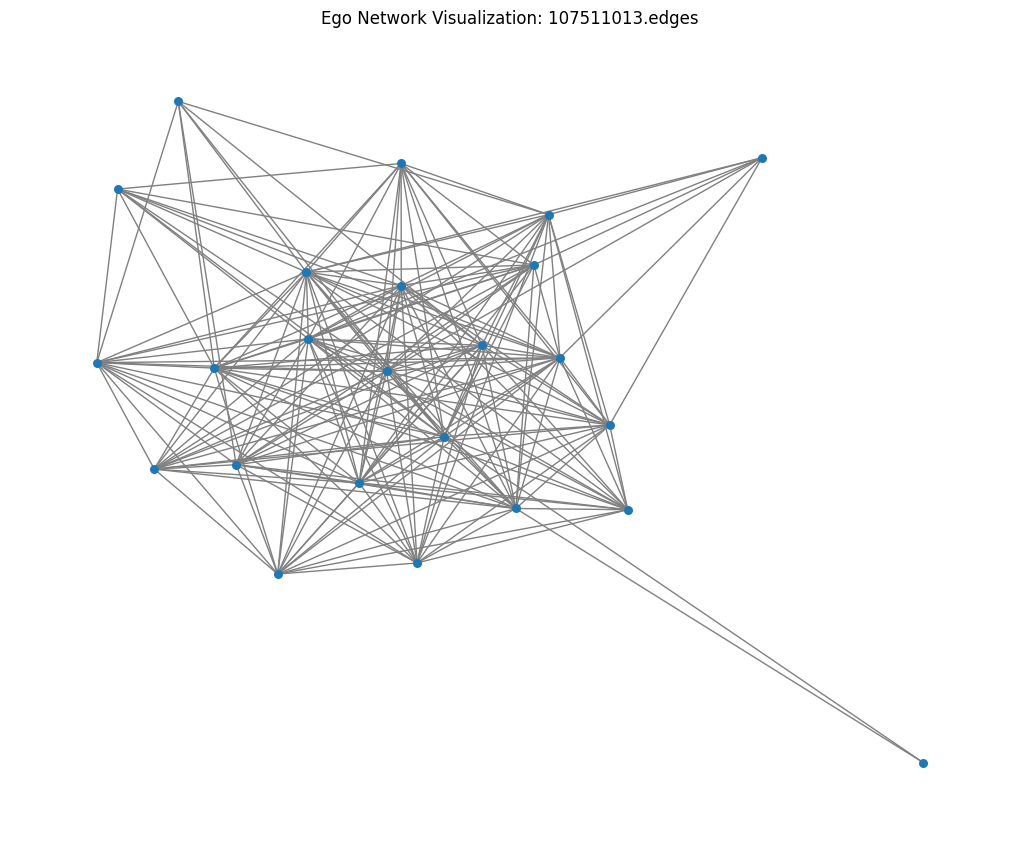

In [8]:
# Plot the ego network
plt.figure(figsize=(10, 8))
nx.draw(G, node_size=30, edge_color="gray", with_labels=False)
plt.title(f"Ego Network Visualization: {edge_files[0]}")
plt.show()


Highly clustered --> dense connection; some isolated nodes  

Loading all the graphs:

In [9]:
# Load all edge files
graphs = [load_graph(os.path.join(data_folder, f)) for f in edge_files]

# Combine graphs if needed (assuming it's an undirected graph)
G_combined = nx.Graph()
for G in graphs:
    G_combined.add_edges_from(G.edges())



Degree Distribution Summary (Combined Graph):
count    2576.000000
mean       26.998447
std        27.171801
min         1.000000
25%         8.000000
50%        18.000000
75%        38.000000
max       270.000000
dtype: float64


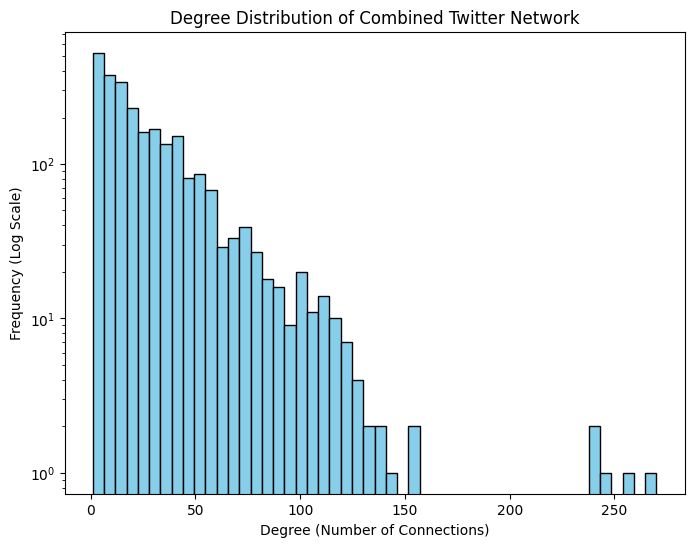

In [10]:
degree_dict_combined = dict(G_combined.degree())  # Compute degree for all nodes
degree_series_combined = pd.Series(degree_dict_combined)  # Convert to Pandas Series

# Print summary statistics
print("Degree Distribution Summary (Combined Graph):")
print(degree_series_combined.describe())

#plot degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degree_series_combined, bins=50, color='skyblue', edgecolor='black', log=True)  # Log scale
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution of Combined Twitter Network")
plt.show()



Most nodes have low connectivity (1–50 connections) --> low-degree nodes
A small number of nodes are highly connected --> high-degree nodes

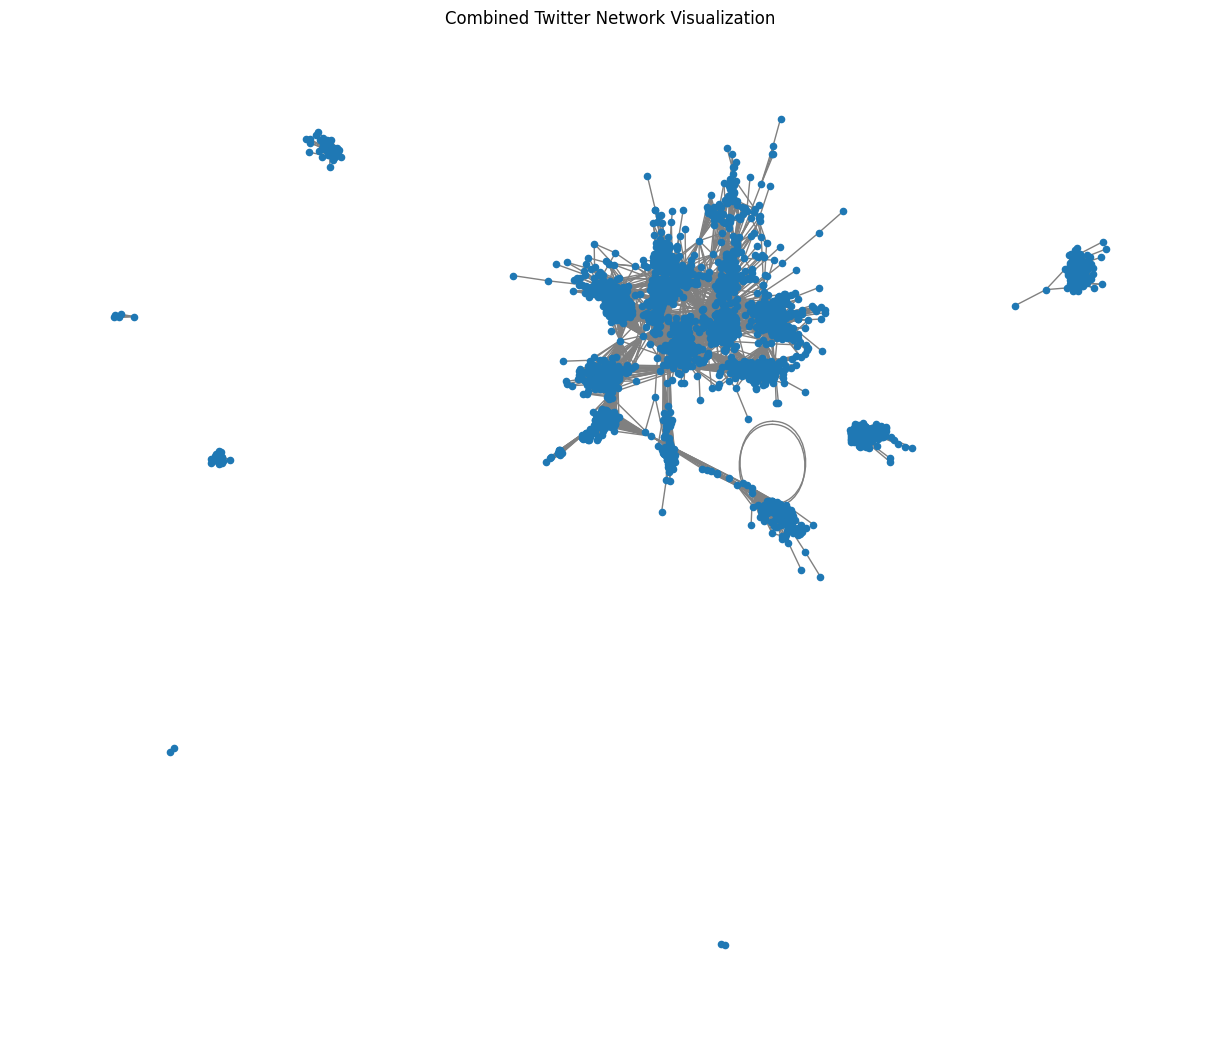

In [11]:
plt.figure(figsize=(12, 10))
nx.draw(G_combined, node_size=20, edge_color="gray", with_labels=False)
plt.title("Combined Twitter Network Visualization")
plt.show()


The center of the network has many interconnected nodes, there are several small clusters on the edges, multiple ego networks interacting

In [12]:
print("Combined Graph Statistics:")
print(f"Total number of nodes: {G_combined.number_of_nodes()}")
print(f"Total number of edges: {G_combined.number_of_edges()}")
print(f"Graph Density: {nx.density(G_combined):.4f}")

Combined Graph Statistics:
Total number of nodes: 2576
Total number of edges: 34774
Graph Density: 0.0105


there are 2576 users, 34 774 connections between them --> connections > users so multiple connections 
most users are not connected to each other directly (low density) but through intermediaries 

In [13]:
# Load feature names
featnames_path = os.path.join(data_folder, edge_files[0].replace(".edges", ".featnames"))
feat_names = pd.read_csv(featnames_path, sep=" ", header=None)
print(feat_names.head())


   0      1
0  0     #4
1  1    #FF
2  2  #FF!!
3  3  #FF's
4  4   #FF,


maybe features correspond to hashtags, interests or groups that users are part of.

In [14]:
# Get all .featnames files in the dataset
featname_files = [f for f in os.listdir(data_folder) if f.endswith('.featnames')]

# Initialize a Counter to count feature occurrences
feature_counter = Counter()

# Read each .featnames file and count occurrences
for file in featname_files:
    featnames_path = os.path.join(data_folder, file)
    
    # Read feature names file
    with open(featnames_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)  # Split ID and feature name
            if len(parts) > 1:  # Ensure there is a feature name
                feature_name = parts[1]
                feature_counter[feature_name] += 1

# Get the 5 most common feature names
top_features = feature_counter.most_common(5)

# Display results
print("Top 5 Most Frequent Feature Names:")
for name, count in top_features:
    print(f"{name}: {count} occurrences")

Top 5 Most Frequent Feature Names:
#FF: 19 occurrences
@youtube: 16 occurrences
#ff: 15 occurrences
#...: 14 occurrences
#1: 14 occurrences


The fact that the most frequent feature appears only 19 times among 2,576 nodes suggests that features alone are unlikely to be the primary driver of connectivity --> edges not features determine the network structure 

In [15]:
# Load node features
feat_path = os.path.join(data_folder, edge_files[0].replace(".edges", ".feat"))
features = pd.read_csv(feat_path, sep=" ", header=None)
print(features.head())


         0    1    2    3    4    5    6    7    8    9    ...  152  153  154  \
0  225444667    1    1    1    0    0    0    0    0    1  ...    0    0    0   
1   28465635    0    1    0    0    0    0    0    0    0  ...    0    0    0   
2  256373594    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3  123371682    0    1    0    1    0    0    1    0    0  ...    0    0    0   
4  259842341    0    0    0    0    0    0    1    0    0  ...    1    0    0   

   155  156  157  158  159  160  161  
0    0    0    0    0    1    1    1  
1    0    0    0    1    0    0    0  
2    0    0    0    0    0    0    0  
3    0    1    0    0    1    0    1  
4    0    0    1    0    1    0    1  

[5 rows x 162 columns]


each row is different user and each column is a different feature
the features are binary values which suggests that it indicated if the user posseses a specific feature 

In [16]:
num_nodes = features.shape[0]
num_features = features.shape[1] - 1  # First column is likely the node ID

print(f"Total Nodes with Features: {num_nodes}")
print(f"Each Node has {num_features} Features")


Total Nodes with Features: 26
Each Node has 161 Features


In [17]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series_combined.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series_combined.quantile(0.10)   # Bottom 10% least connected nodes

# Extract nodes based on their degree
high_degree_nodes = degree_series_combined[degree_series_combined >= high_degree_threshold].index
low_degree_nodes = degree_series_combined[degree_series_combined <= low_degree_threshold].index

# Print results
print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 259
Low-degree Nodes: 270


close in size (256 vs 270) - balances comparison 

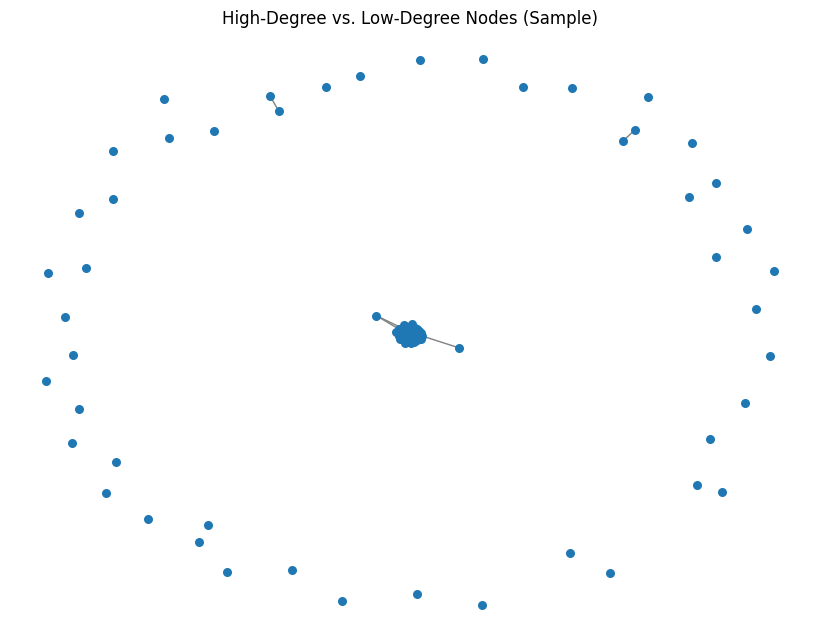

In [18]:
# Sample a subset of high-degree and low-degree nodes for visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G_combined.subgraph(subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


high-degree nodes form a central cluster and  low-degree nodes are more scattered in the periphery

In [19]:
# Path to the Twitter dataset folder
data_folder = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Twitter dataset/archive/data/twitter"

# Find the first available edge and feature file
edge_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.edges')])
feat_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.feat')])

if not edge_files or not feat_files:
    raise ValueError("No valid .edges or .feat files found in the dataset folder.")

# Select the first available dataset
edge_file = os.path.join(data_folder, edge_files[0])
feat_file = os.path.join(data_folder, feat_files[0])

print(f"Using dataset: {edge_file} & {feat_file}")


Using dataset: /Users/martynazimek/Desktop/Thesis/thesis_social_networks/Twitter dataset/archive/data/twitter/100318079.edges & /Users/martynazimek/Desktop/Thesis/thesis_social_networks/Twitter dataset/archive/data/twitter/100318079.feat


In [20]:
def load_graph(edge_file, sample_size=10000):
    """Loads a subset of the Twitter graph from an edge list file."""
    try:
        # Load edges
        edges = pd.read_csv(edge_file, sep=" ", names=["id_1", "id_2"], header=None)

        # Debugging: Print original size
        print(f"Total edges in file: {len(edges)}")

        # Ensure correct sampling: Limit dataset size BEFORE using it in DGL
        edges = edges.sample(n=min(sample_size, len(edges)), random_state=42)

        # Debugging: Print after sampling
        print(f"Sampled edges: {len(edges)}")

        src, dst = edges["id_1"].values, edges["id_2"].values

        # Create DGL graph
        graph = dgl.graph((src, dst))
        graph = dgl.add_self_loop(graph)  # Add self-loops to avoid issues in GNNs

        print(f"Graph loaded: {graph.num_nodes()} nodes, {graph.num_edges()} edges")
        return graph

    except Exception as e:
        print(f"Error loading graph: {e}")
        return None


In [21]:
def load_graph(edge_file, sample_size=50000):
    """Loads a subset of the Twitter graph from an edge list file."""
    try:
        # Load edges
        edges = pd.read_csv(edge_file, sep=" ", names=["id_1", "id_2"], header=None)

        # Debugging: Print original size
        print(f"Total edges in file: {len(edges)}")

        # Ensure correct sampling: Limit dataset size BEFORE using it in DGL
        edges = edges.sample(n=min(sample_size, len(edges)), random_state=42)

        # Debugging: Print after sampling
        print(f"Sampled edges: {len(edges)}")

        src, dst = edges["id_1"].values, edges["id_2"].values

        # Create DGL graph
        graph = dgl.graph((src, dst))
        graph = dgl.add_self_loop(graph)  # Add self-loops to avoid issues in GNNs

        print(f"Graph loaded: {graph.num_nodes()} nodes, {graph.num_edges()} edges")
        return graph

    except Exception as e:
        print(f"Error loading graph: {e}")
        return None


In [22]:
def load_features(feat_file, graph, max_nodes=50000):
    """Loads node features and aligns them with the graph nodes (subset for large datasets)."""
    try:
        # Load features
        features = pd.read_csv(feat_file, sep=" ", header=None)

        # Debugging: Print original feature size
        print(f"Total nodes in feature file: {len(features)}")

        # Limit dataset size for debugging
        features = features.iloc[:max_nodes, :]

        # Debugging: Print after sampling
        print(f"Sampled feature nodes: {len(features)}")

        node_ids = features.iloc[:, 0].values  # First column = Node IDs
        feature_matrix = features.iloc[:, 1:].values  # Remaining columns = Features

        # Convert features to dictionary
        feature_dict = {node_id: feature_matrix[i] for i, node_id in enumerate(node_ids)}

        # Align features with the graph nodes
        aligned_features = []
        for node in graph.nodes().numpy():
            if node in feature_dict:
                aligned_features.append(feature_dict[node])
            else:
                aligned_features.append(np.zeros(feature_matrix.shape[1]))  # Fill missing features with zeros

        feature_tensor = torch.tensor(np.array(aligned_features), dtype=torch.float32)

        print(f"Features loaded: {feature_tensor.shape[0]} nodes, {feature_tensor.shape[1]} features")
        return feature_tensor

    except Exception as e:
        print


In [ ]:
# Print first 5 lines of the edge file
with open(edge_file, "r") as f:
    print(f.readlines()[:5])

# Print first 5 lines of the feature file
with open(feat_file, "r") as f:
    print("Feature file sample:", f.readlines()[:10])  # Check first 10 lines



['214328887 34428380\n', '17116707 28465635\n', '380580781 18996905\n', '221036078 153460275\n', '107830991 17868918\n']
Feature file sample: ['35415466 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

: 

In [ ]:
graph = load_graph(edge_file, sample_size=50000)

if graph:
    features = load_features(feat_file, graph, max_nodes=50000)
    if features is not None:
        print(f"Final Graph: {graph.num_nodes()} nodes, Feature Matrix Shape: {features.shape}")


Total edges in file: 8354
Sampled edges: 8354
Graph loaded: 529007328 nodes, 529015682 edges
Total nodes in feature file: 220
Sampled feature nodes: 220
